In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

In [2]:
uploaded = files.upload()
data = pd.read_csv('H3.txt', sep = '\n')
print(data.head())

Saving H3.txt to H3.txt
                                            all_data
0                                     >iTELL-Chr1_61
1  CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...
2                                                  0
3                                   >iYAL067W-A_5085
4  AATTTTTATAGGTCGACCCTTCTGTCGCTTACTGGGTTGATTATCT...


In [3]:
all=data["all_data"].tolist()
cls=[]
sequence=[]
label=[]

In [4]:
length = len(all)
for i in range(length):
   if (i%3)==0:
             cls.append(all[i])
   else:
      if(all[i]== "0" or all[i]=="1"):
        label.append(all[i])
      else:
         sequence.append(all[i])

print(len(cls))
print(len(label))
print(len(sequence))

14965
14965
14965


In [5]:
df = pd.DataFrame(list(zip(cls, label, sequence)),
               columns =['classification' , 'label', 'sequence'])
df.head(10)

,classification,label,sequence
0,>iTELL-Chr1_61,0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...
1,>iYAL067W-A_5085,0,AATTTTTATAGGTCGACCCTTCTGTCGCTTACTGGGTTGATTATCT...
2,>iYAL067W-A_6786,0,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...
3,>iYAL067W-A_7060,0,AACAATAGTGGGTATGAGTAAAGATATATAGATCGATATTTTGAAT...
4,>YAL067C_SEO1_8061,1,CAAAGATTTCAACCATAGTAGGTATGCCCCAGATGAAACATTACTG...
5,>YAL067C_SEO1_8340,1,CACAATAGCGTCAATAATAAAGTTCCATCTCCATCCCTCTAAACCA...
6,>iYAL067C_9509,1,GTTTTTTTCCAGTGACACAATCTTTACCATTACACAGTTTTTACTA...
7,>iYAL067C_10442,0,CAGAAACATAAAATTATATCACTTTATTTCATATGGTTTCATGCTT...
8,>YAL065C_YAL065C_11570,1,AGATACCTCGAAACAAACTCTATGTAAACACTTATTTTATTGTGGT...
9,>iYAL064W-B_13286,1,ATGACTGGAGAAGAAGTGACTAGAGAAGAAGTGACTGAGGAAGAAA...


In [6]:
labels = list(df.loc[:,'label'])
print(type(labels))

<class 'list'>


In [7]:
sequences = list(df.loc[:, 'sequence'])
print(type(sequences))
seqqq=sequences

<class 'list'>


In [8]:
seqs = df.sequence.values


In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in seqqq:
 
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())


In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
max_length=500
input_features = sequence.pad_sequences(input_features, maxlen=max_length)


In [11]:
input_features = input_features.astype('float64')

In [12]:
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CACACCACAC ... GTTCTTCTAC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [13]:
labels = list(filter(None, label))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '1' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=.25, random_state=42)


In [15]:
X_train.shape

(11223, 500, 4)

In [16]:
y_train.shape

(11223, 2)

In [23]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD, Adam

model = Sequential()
model.add(Conv1D(1, 41, padding='same', input_shape=(X_train.shape[1], 4), activation='relu'))

model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(10, 20, padding='same', input_shape=(X_train.shape[1], 4), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
#model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 500, 1)            165       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 125, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 125, 10)           210       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 62, 10)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 620)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                12420     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Epoch 1/15
88/88 [==============================] - 8s 71ms/step - loss: 0.6953 - accuracy: 0.5066 - val_loss: 0.6926 - val_accuracy: 0.5120
Epoch 2/15
88/88 [==============================] - 6s 66ms/step - loss: 0.6915 - accuracy: 0.5099 - val_loss: 0.6640 - val_accuracy: 0.5123
Epoch 3/15
88/88 [==============================] - 6s 66ms/step - loss: 0.6390 - accuracy: 0.6362 - val_loss: 0.5664 - val_accuracy: 0.7830
Epoch 4/15
88/88 [==============================] - 6s 66ms/step - loss: 0.5510 - accuracy: 0.7896 - val_loss: 0.4552 - val_accuracy: 0.8004
Epoch 5/15
88/88 [==============================] - 6s 67ms/step - loss: 0.4700 - accuracy: 0.7882 - val_loss: 0.4547 - val_accuracy: 0.7977
Epoch 6/15
88/88 [==============================] - 6s 66ms/step - loss: 0.4604 - accuracy: 0.7933 - val_loss: 0.4478 - val_accuracy: 0.8022
Epoch 7/15
88/88 [==============================] - 6s 65ms/step - loss: 0.4686 - accuracy: 0.7997 - val_loss: 0.4477 - val_accuracy: 0.7993
Epoch 8/15
88

In [25]:

from sklearn.metrics import accuracy_score


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))


train-acc = 0.8072707832130447
test-acc = 0.7966328166755745


Confusion matrix:
 [[1440  386]
 [ 375 1541]]


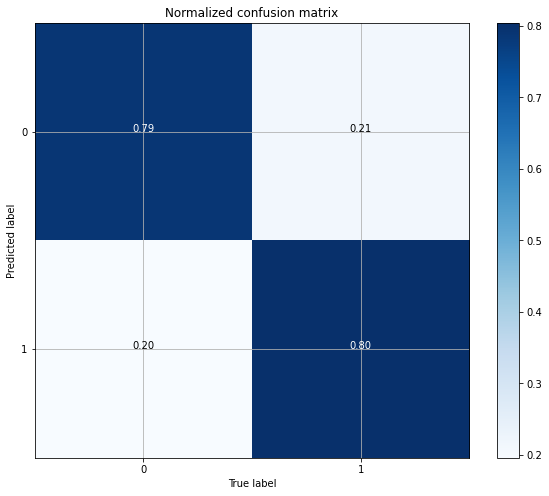

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [ ]:
##############################################################################################

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D


model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 4)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [31]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Epoch 1/15
88/88 [==============================] - 41s 445ms/step - loss: 0.6656 - accuracy: 0.5819 - val_loss: 0.5612 - val_accuracy: 0.6911
Epoch 2/15
88/88 [==============================] - 39s 443ms/step - loss: 0.5607 - accuracy: 0.7239 - val_loss: 0.4908 - val_accuracy: 0.7830
Epoch 3/15
88/88 [==============================] - 39s 448ms/step - loss: 0.5327 - accuracy: 0.7403 - val_loss: 0.5482 - val_accuracy: 0.7223
Epoch 4/15
88/88 [==============================] - 39s 448ms/step - loss: 0.5167 - accuracy: 0.7551 - val_loss: 0.4904 - val_accuracy: 0.7835
Epoch 5/15
88/88 [==============================] - 39s 448ms/step - loss: 0.5163 - accuracy: 0.7523 - val_loss: 0.4822 - val_accuracy: 0.7835
Epoch 6/15
88/88 [==============================] - 40s 450ms/step - loss: 0.5094 - accuracy: 0.7637 - val_loss: 0.6341 - val_accuracy: 0.6587
Epoch 7/15
88/88 [==============================] - 40s 457ms/step - loss: 0.5044 - accuracy: 0.7629 - val_loss: 0.4729 - val_accuracy: 0.7940

In [32]:
from sklearn.metrics import accuracy_score


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))


train-acc = 0.7828566336986545
test-acc = 0.7830037413148049


Confusion matrix:
 [[1612  214]
 [ 598 1318]]


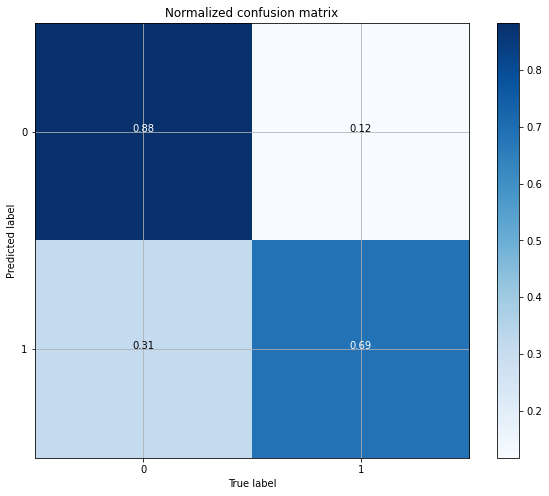

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [ ]:
###################################################End##############################################33

####  ***Run Shallow Convolutional Neural Network******




In [18]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l1

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform', 
                 input_shape=(X_train.shape[1], 4)))
model.add(Activation("relu"))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(16, kernel_initializer= 'he_uniform'))
model.add(Activation("relu"))
model.add(Dense(2, activation='softmax'))

epochs = 20
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 500, 32)           672       
_________________________________________________________________
activation (Activation)      (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           5152      
_________________________________________________________________
activation_1 (Activation)    (None, 500, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Epoch 1/15
88/88 [==============================] - 28s 134ms/step - loss: 0.6965 - binary_accuracy: 0.5161 - val_loss: 0.6924 - val_binary_accuracy: 0.5331
Epoch 2/15
88/88 [==============================] - 11s 128ms/step - loss: 0.6906 - binary_accuracy: 0.5577 - val_loss: 0.6762 - val_binary_accuracy: 0.5436
Epoch 3/15
88/88 [==============================] - 11s 129ms/step - loss: 0.6364 - binary_accuracy: 0.6768 - val_loss: 0.5530 - val_binary_accuracy: 0.7675
Epoch 4/15
88/88 [==============================] - 11s 129ms/step - loss: 0.6594 - binary_accuracy: 0.5817 - val_loss: 0.6961 - val_binary_accuracy: 0.5120
Epoch 5/15
88/88 [==============================] - 11s 129ms/step - loss: 0.6936 - binary_accuracy: 0.5196 - val_loss: 0.6841 - val_binary_accuracy: 0.6900
Epoch 6/15
88/88 [==============================] - 11s 129ms/step - loss: 0.6459 - binary_accuracy: 0.7028 - val_loss: 0.5240 - val_binary_accuracy: 0.7849
Epoch 7/15
88/88 [==============================] - 11s 12

Confusion matrix:
 [[1114  712]
 [ 153 1763]]


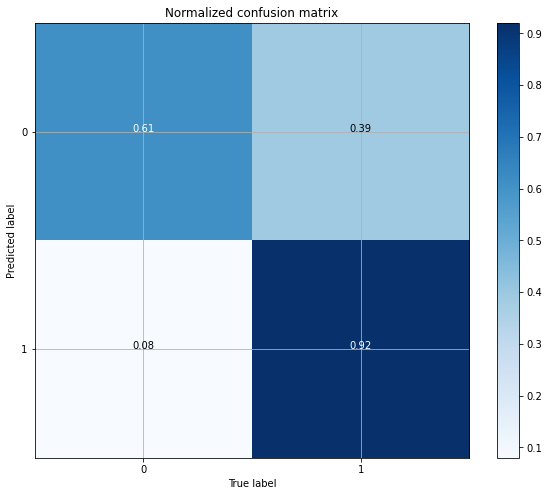

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [21]:

from sklearn.metrics import accuracy_score


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))






train-acc = 0.8288336451929075
test-acc = 0.7688401924104756


In [ ]:
#########################################################################################################

**Run Deep Convolutional Neural Network Here we will configure a 3-block VGG-like Deep Convolutional Neural Network** 


In [34]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l1

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform', 
                 input_shape=(X_train.shape[1], 4)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

epochs = 50
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 500, 32)           672       
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 32)           128       
_________________________________________________________________
activation_3 (Activation)    (None, 500, 32)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 500, 32)           5152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
activation_4 (Activation)    (None, 500, 32)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 250, 32)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Epoch 1/15
88/88 [==============================] - 75s 851ms/step - loss: 0.7942 - binary_accuracy: 0.5626 - val_loss: 0.6238 - val_binary_accuracy: 0.7130
Epoch 2/15
88/88 [==============================] - 75s 851ms/step - loss: 0.7027 - binary_accuracy: 0.6431 - val_loss: 0.5787 - val_binary_accuracy: 0.6785
Epoch 3/15
88/88 [==============================] - 74s 845ms/step - loss: 0.6351 - binary_accuracy: 0.6970 - val_loss: 0.6070 - val_binary_accuracy: 0.6534
Epoch 4/15
88/88 [==============================] - 74s 841ms/step - loss: 0.5896 - binary_accuracy: 0.7349 - val_loss: 0.6876 - val_binary_accuracy: 0.6162
Epoch 5/15
88/88 [==============================] - 74s 846ms/step - loss: 0.5657 - binary_accuracy: 0.7438 - val_loss: 0.7259 - val_binary_accuracy: 0.6149
Epoch 6/15
88/88 [==============================] - 74s 838ms/step - loss: 0.5444 - binary_accuracy: 0.7578 - val_loss: 0.7431 - val_binary_accuracy: 0.6213
Epoch 7/15
88/88 [==============================] - 74s 84

In [37]:
from sklearn.metrics import accuracy_score


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))



train-acc = 0.7134456027800054
test-acc = 0.7100481026189204


Confusion matrix:
 [[1682  144]
 [ 941  975]]


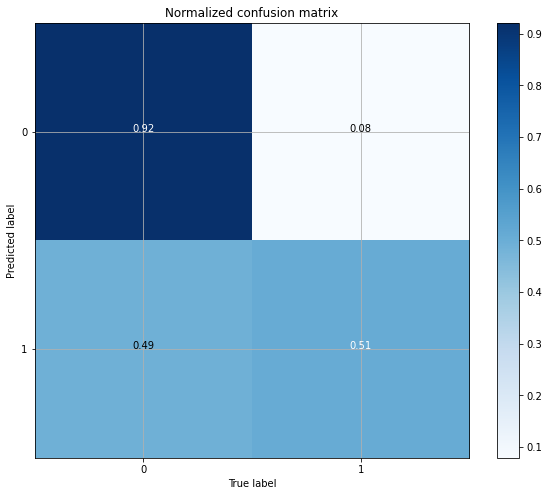

In [38]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()